This is the fifth exercise and it involves estimating parameters in a multi-variate energy balance model with added empirical elements. The predictions are aligned to the measured values through an optimizer that adjusts the parameters to minimize a sum of squared error or sum of absolute values objective. This lab builds upon the TCLab C by using the estimation of parameters in an energy balance but also adding additional equations that give a 2nd order response. The 2nd order response comes from splitting the finite element model of the heaters and temperature sensors. This creates a total of 4 differential equations with parameters that are adjusted to minimize the difference between the predicted and measured temperatures.

In [3]:
import numpy as np
import pandas as pd
import tclab
import time
import matplotlib.pyplot as plt

# generate step test data on Arduino
filename = 'tclab_dyn_data2.csv'

# heater steps
Q1d = np.zeros(601)
Q1d[10:200] = 80
Q1d[200:280] = 20
Q1d[280:400] = 70
Q1d[400:] = 50

Q2d = np.zeros(601)
Q2d[120:320] = 100
Q2d[320:520] = 10
Q2d[520:] = 80

# Connect to Arduino
a = tclab.TCLab()
fid = open(filename,'w')
fid.write('Time,H1,H2,T1,T2\n')
fid.close()

# run step test (10 min)
for i in range(601):
    # set heater values
    a.Q1(Q1d[i])
    a.Q2(Q2d[i])
    print('Time: ' + str(i) + \
          ' H1: ' + str(Q1d[i]) + \
          ' H2: ' + str(Q2d[i]) + \
          ' T1: ' + str(a.T1)   + \
          ' T2: ' + str(a.T2))
    # wait 1 second
    time.sleep(1)
    fid = open(filename,'a')
    fid.write(str(i)+','+str(Q1d[i])+','+str(Q2d[i])+',' \
              +str(a.T1)+','+str(a.T2)+'\n')
# close connection to Arduino
a.close()

# read data file
data = pd.read_csv(filename)

# plot measurements
plt.figure()
plt.subplot(2,1,1)
plt.plot(data['Time'],data['H1'],'r-',label='Heater 1')
plt.plot(data['Time'],data['H2'],'b--',label='Heater 2')
plt.ylabel('Heater (%)')
plt.legend(loc='best')
plt.subplot(2,1,2)
plt.plot(data['Time'],data['T1'],'r.',label='Temperature 1')
plt.plot(data['Time'],data['T2'],'b.',label='Temperature 2')
plt.ylabel('Temperature (degC)')
plt.legend(loc='best')
plt.xlabel('Time (sec)')
plt.savefig('tclab_dyn_meas2.png')

plt.show()

TCLab version 0.4.9
Arduino Leonardo connected on port /dev/ttyACM0 at 115200 baud.
TCLab Firmware 2.0.1 Arduino Leonardo/Micro.
Time: 0 H1: 0.0 H2: 0.0 T1: 39.268 T2: 28.633
Time: 1 H1: 0.0 H2: 0.0 T1: 38.945 T2: 28.665
Time: 2 H1: 0.0 H2: 0.0 T1: 38.945 T2: 28.729
Time: 3 H1: 0.0 H2: 0.0 T1: 38.945 T2: 28.826


KeyboardInterrupt: 

# Parameter Estimation

apm 10.32.114.116_gk_model19 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            1
   Variables    :           16
   Intermediates:            0
   Connections  :            0
   Equations    :            4
   Residuals    :            4
 
 Number of state variables:          19172
 Number of total equations: -        19168
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              4
 
 **********************************************
 Dynamic Estimation with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program contains 

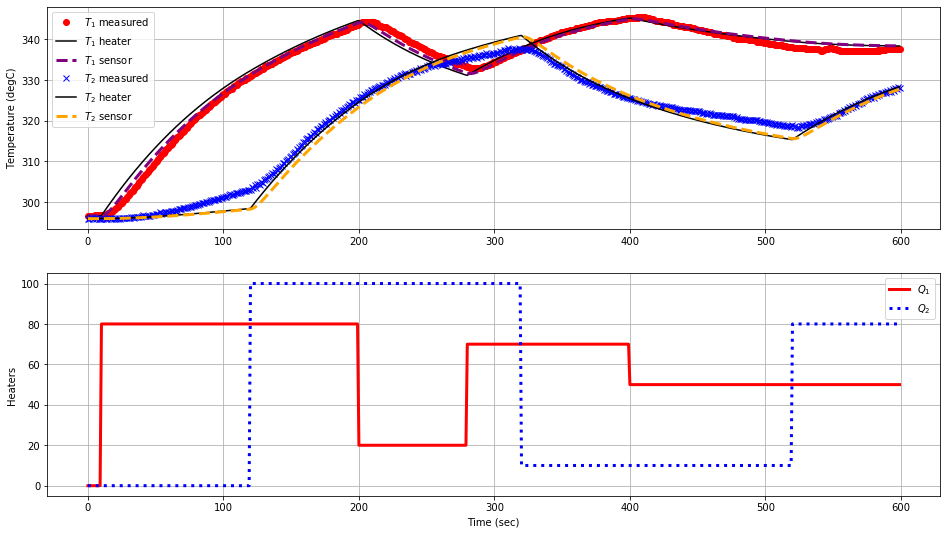

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from gekko import GEKKO

#load data that we are trying to fit to
filename = 'tclab_dyn_data2.csv'
data = pd.read_csv(filename)

#create gekko model based on lab handout. There are two first-principles equations and two additional empirical equations that model temperature delay between heater and sensor
m = GEKKO()
m.time = data['Time'].values

#lab handout suggests estimating the following:
#U: overall heat transfer coefficient.
#alphai: heater factor W/%
#tau: time constant between heater and temp sensor

#fixed values because same value over horizon
U = m.FV(value=10, lb=1, ub=20)
alpha1 = m.FV(value=.01, lb=.001, ub = .1)
alpha2 = m.FV(value=.0075, lb=.001, ub = .1)
tau = m.FV(value=15,lb=5,ub=25) #no idea what this should be.... tau from labD was 15sih.

#let optimizer adjust these things from time step to time step
U.STATUS = 1
alpha1.STATUS = 1
alpha2.STATUS = 1
tau.STATUS = 1

#physical parameters and constants
sigma = m.Const(5.67e-8)
epsilon = m.Param(.9)
mass = m.Param(.004)
As = m.Param(2e-4)
A = m.Param(1e-3)
Cp = m.Param(500)
Tinf = m.Param(296.15)

#variables we are using to fit with, error based estimation
# We only have the sensor temperatures, so that's what we are doing estimation with
#load gekko with data, convert to Kelvin to match params
Tc1 = m.CV(value=(data['T1']+273.15).values, lb=0, ub=200+273.15)
Tc2 = m.CV(value=(data['T2']+273.15).values, lb=0, ub=200+273.15)

#state variables, can initialize to 0, but 'warm starting with a guess of Tcs makes sense
# without this, the th estimates have to converge and it takes a while. 
Th1 = m.SV(value=(data['T1']+273.15).values)
Th2 = m.SV(value=(data['T2']+273.15).values)

#inputs
Q1 = m.MV(value=data['H1'].values)
Q2 = m.MV(value=data['H2'].values)


#first principles models, energy balance
m.Equation(mass*Cp*Th1.dt() == U*A*(Tinf - Th1) + epsilon * sigma * A *(Tinf**4 - Th1**4) + U*As*(Th2 - Th1) + epsilon * sigma * As *(Th2**4 - Th1**4) + alpha1*Q1)
m.Equation(mass*Cp*Th2.dt() == U*A*(Tinf - Th2) + epsilon * sigma * A *(Tinf**4 - Th2**4) + U*As*(Th1 - Th2) + epsilon * sigma * As *(Th1**4 - Th2**4) + alpha2*Q2)

#empirical models
m.Equation(tau*Tc1.dt() == -Tc1 + Th1)
m.Equation(tau*Tc2.dt() == -Tc2 + Th2)

# Options
m.options.IMODE   = 5 # MHE
m.options.EV_TYPE = 2 # Objective type
m.options.NODES   = 2 # Collocation nodes
m.options.SOLVER  = 3 # IPOPT

# Solve
m.solve(disp=True)

# Parameter values
print('U     : ' + str(U.value[0]))
print('tau   : ' + str(tau.value[0]))
print('alpha1: ' + str(alpha1.value[0]))
print('alpha2: ' + str(alpha2.value[0]))

# Create plot
plt.figure(figsize=(16,9))
ax=plt.subplot(2,1,1)
ax.grid()
plt.plot(data['Time'],data['T1']+273.15,'ro',label=r'$T_1$ measured')
plt.plot(m.time,Th1.value,'k-',label=r'$T_1$ heater')
plt.plot(m.time,Tc1.value,color='purple',linestyle='--',\
         lw=3,label=r'$T_1$ sensor')
plt.plot(data['Time'],data['T2']+273.15,'bx',label=r'$T_2$ measured')
plt.plot(m.time,Th2.value,'k-',label=r'$T_2$ heater')
plt.plot(m.time,Tc2.value,color='orange',linestyle='--',\
         lw=3,label=r'$T_2$ sensor')
plt.ylabel('Temperature (degC)')
plt.legend(loc=2)
ax=plt.subplot(2,1,2)
ax.grid()
plt.plot(data['Time'],data['H1'],'r-',\
         lw=3,label=r'$Q_1$')
plt.plot(data['Time'],data['H2'],'b:',\
         lw=3,label=r'$Q_2$')
plt.ylabel('Heaters')
plt.xlabel('Time (sec)')
plt.legend(loc='best')
plt.show()

# MHE starting with Estimated Parameters

TCLab version 0.4.9
Arduino Leonardo connected on port /dev/ttyACM0 at 115200 baud.
TCLab Firmware 2.0.1 Arduino Leonardo/Micro.


<Figure size 720x504 with 0 Axes>

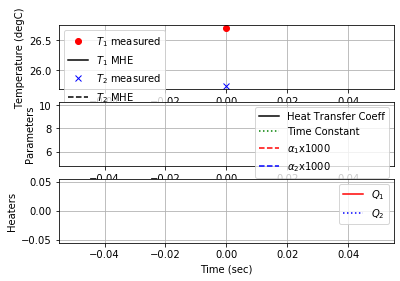

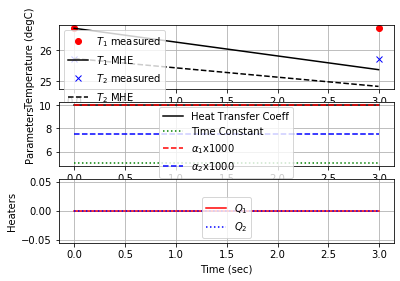

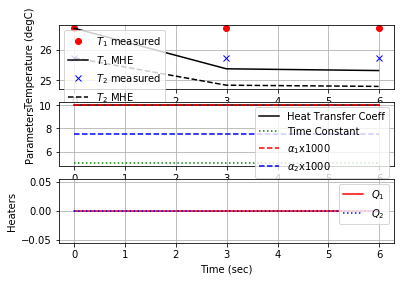

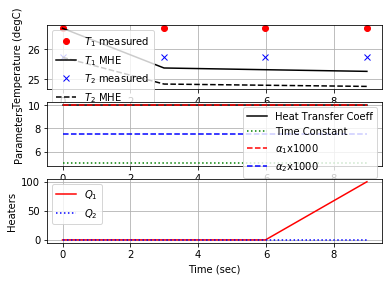

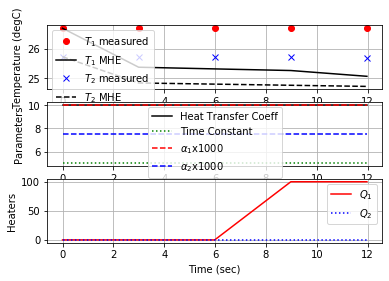

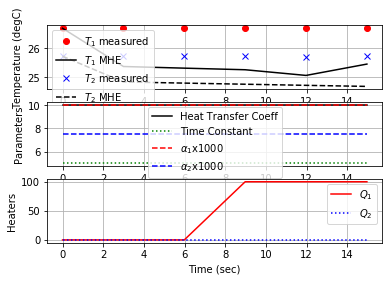

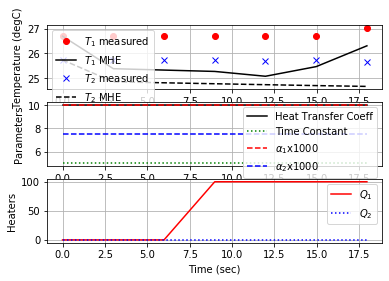

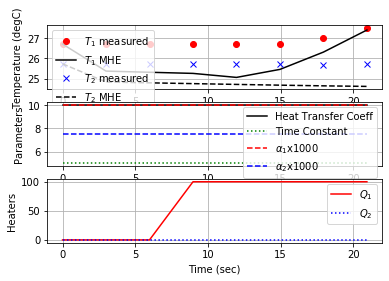

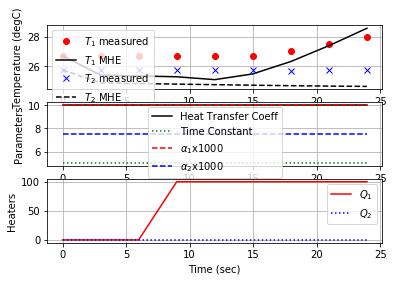

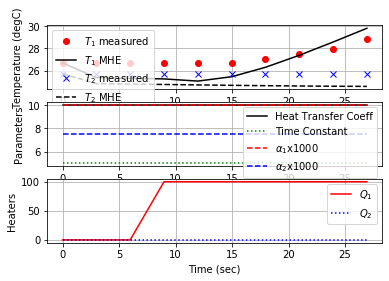

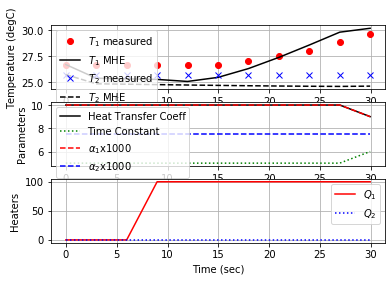

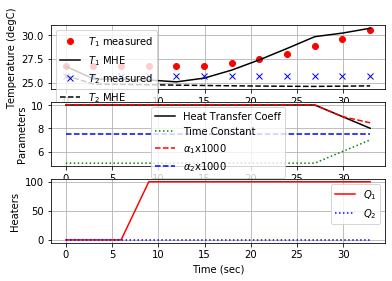

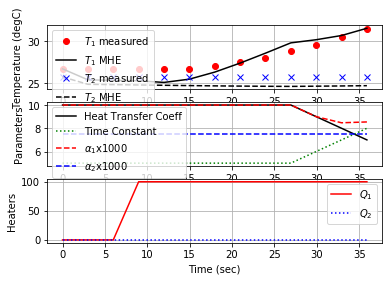

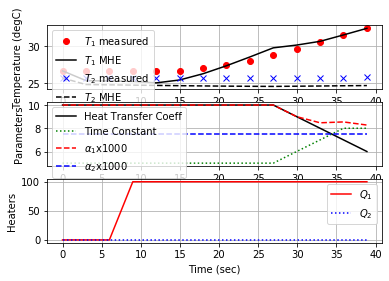

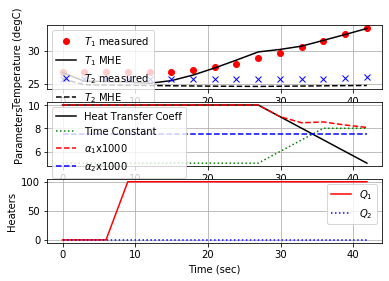

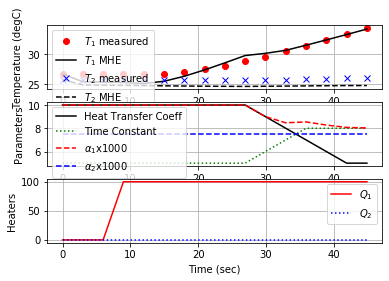

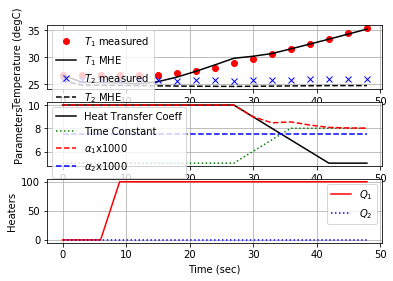

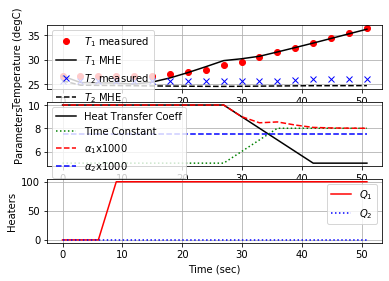

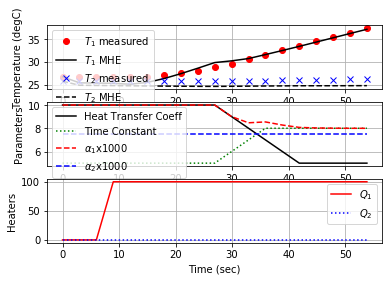

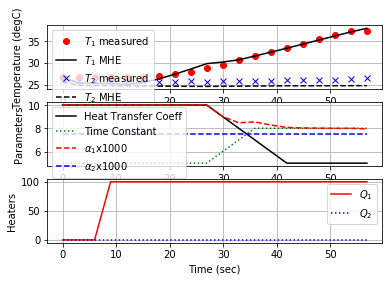

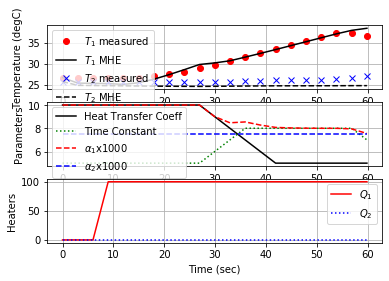

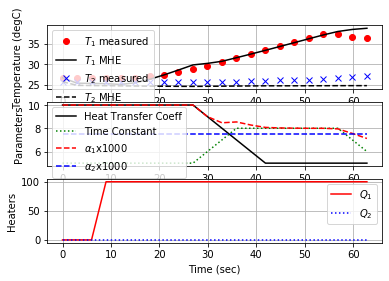

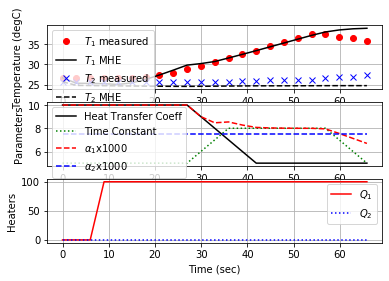

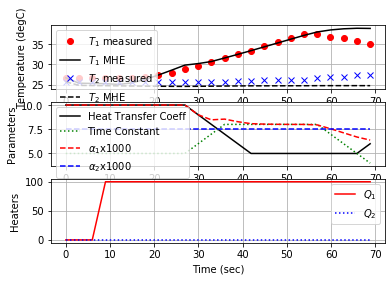

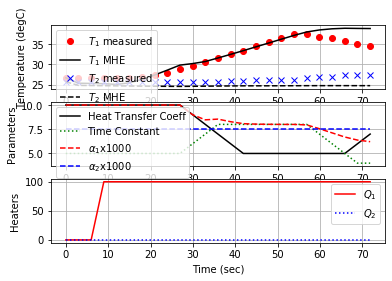

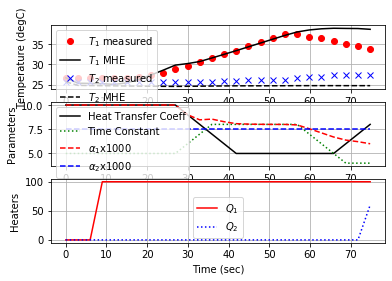

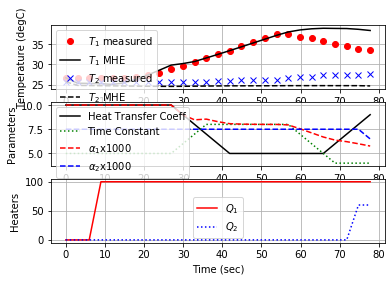

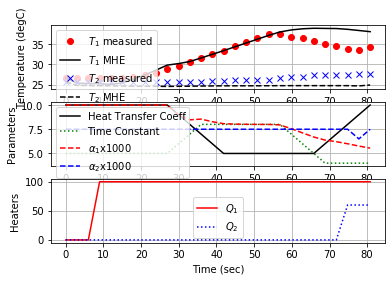

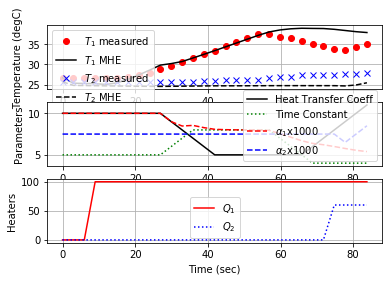

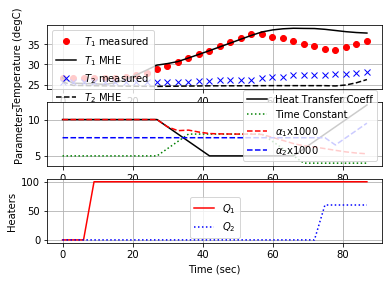

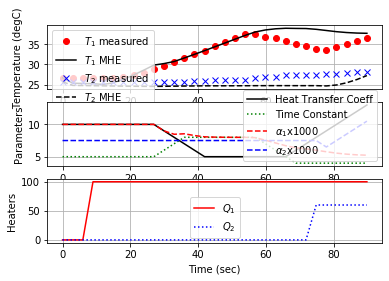

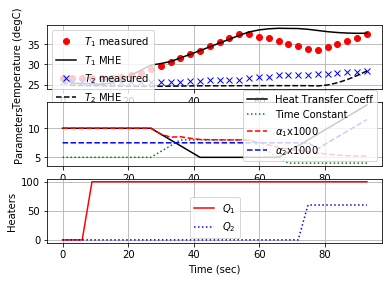

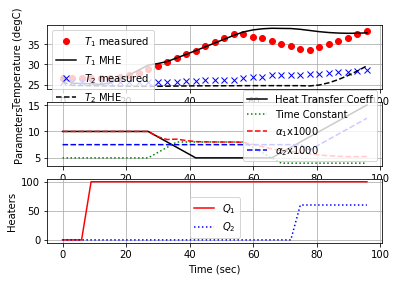

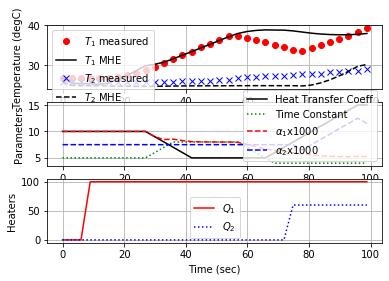

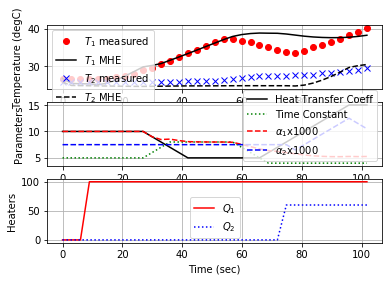

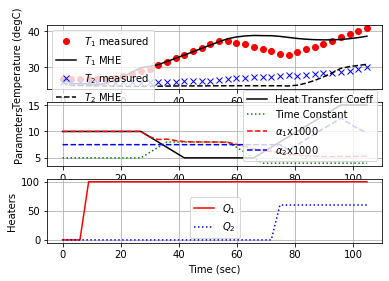

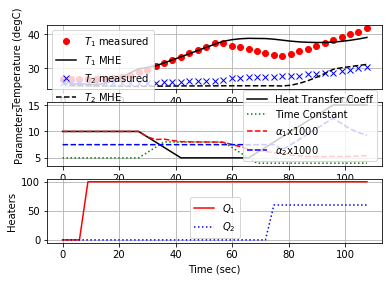

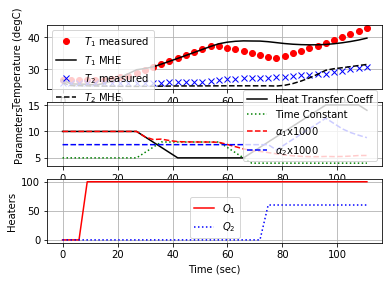

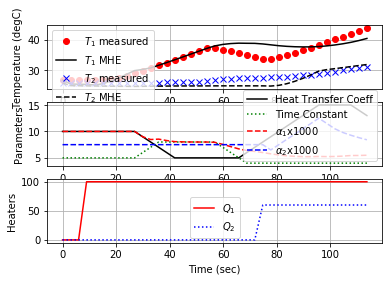

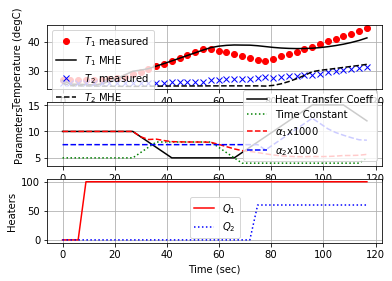

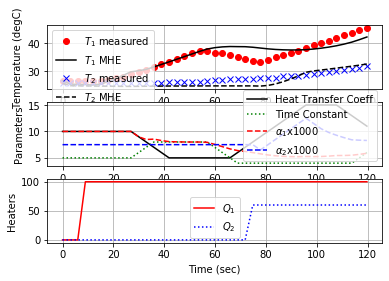

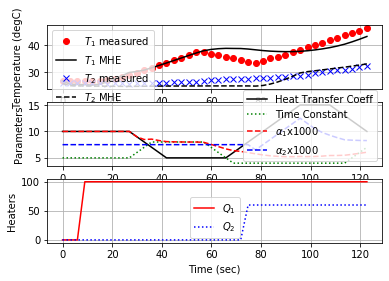

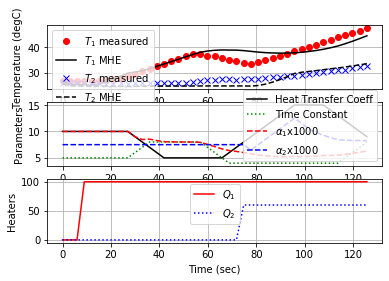

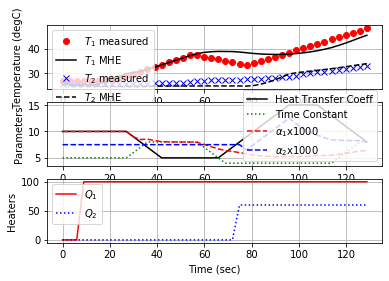

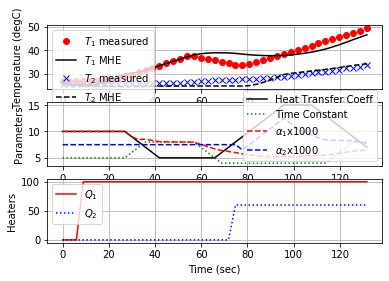

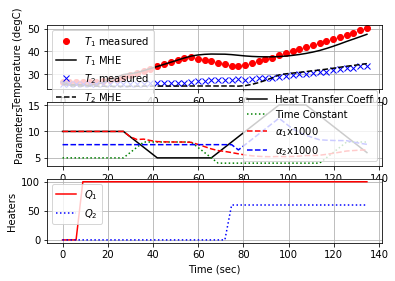

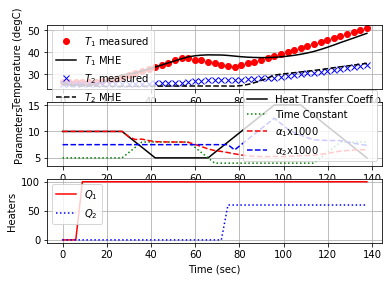

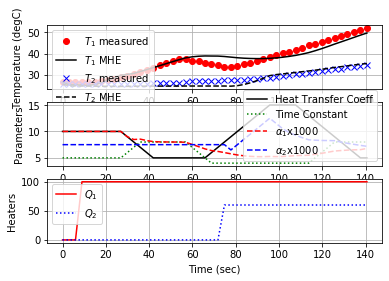

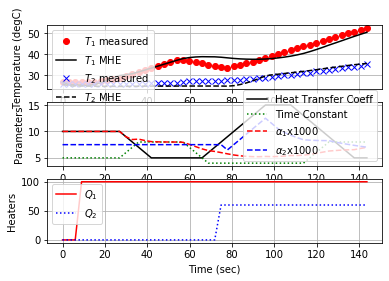

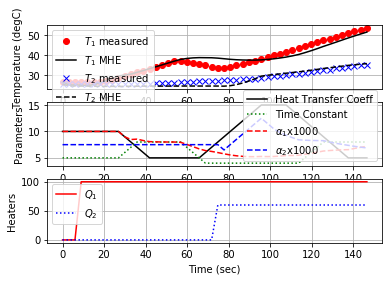

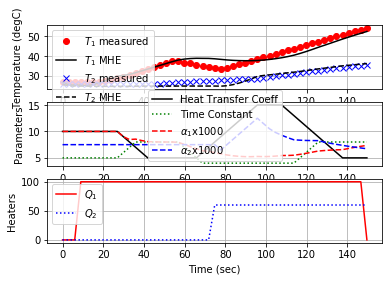

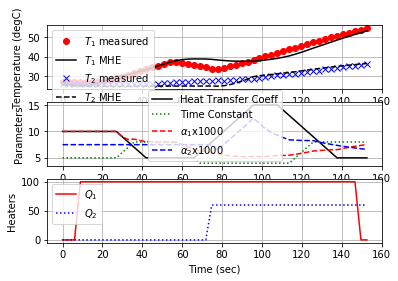

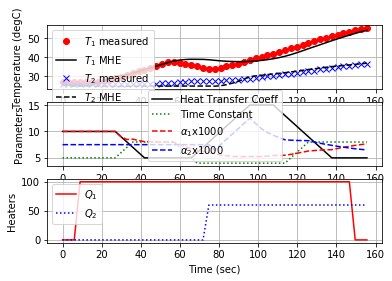

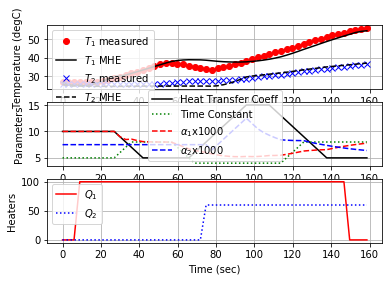

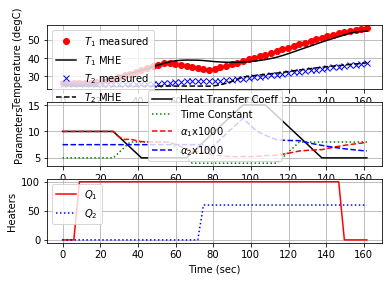

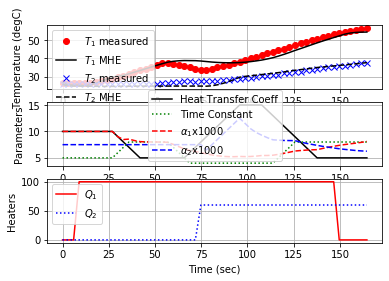

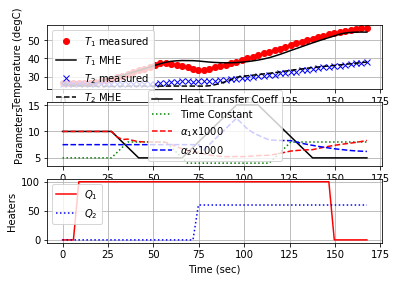

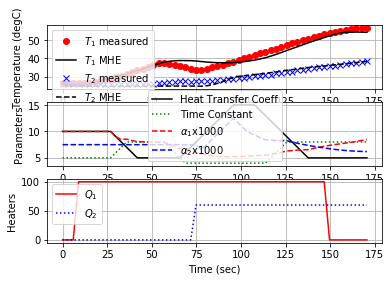

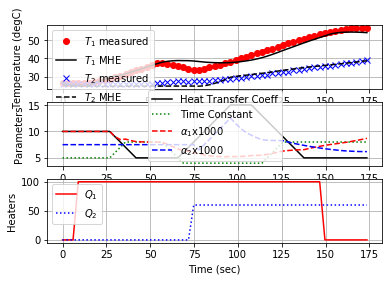

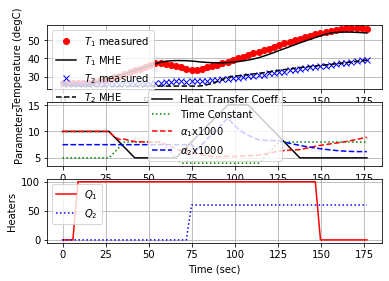

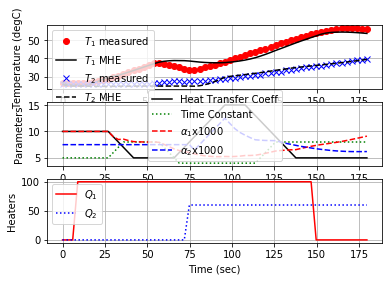

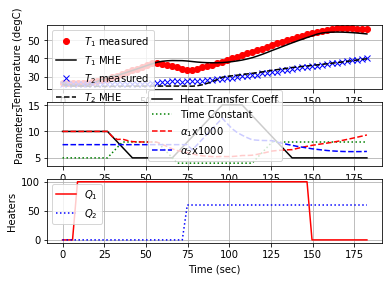

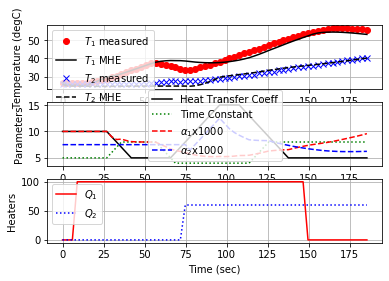

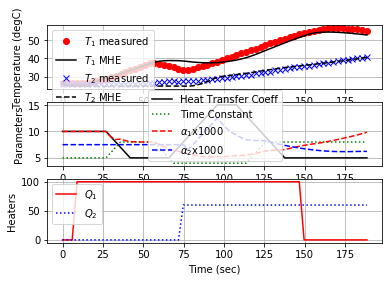

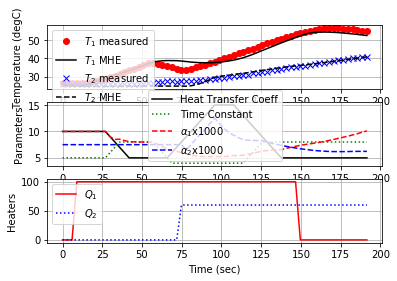

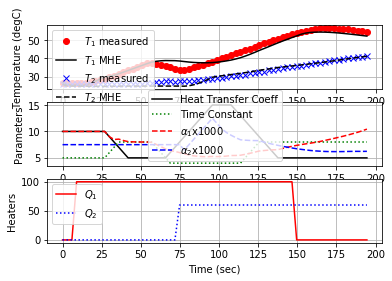

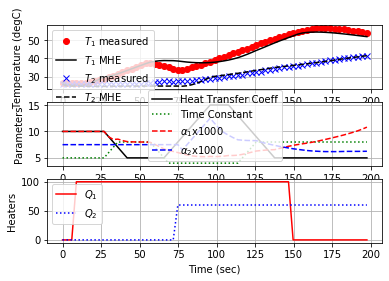

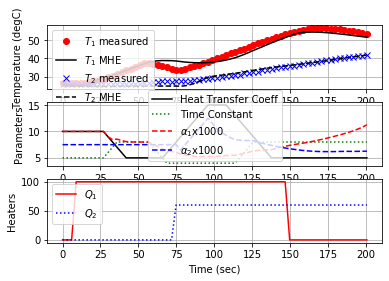

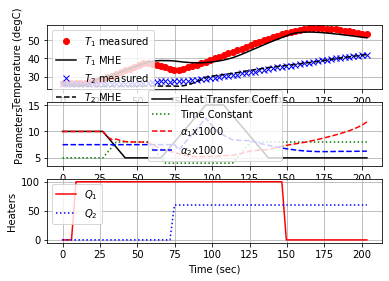

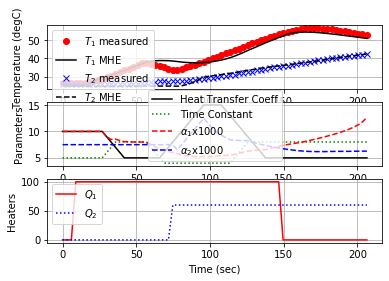

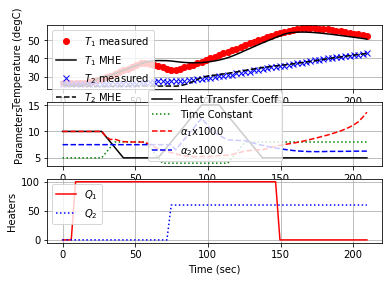

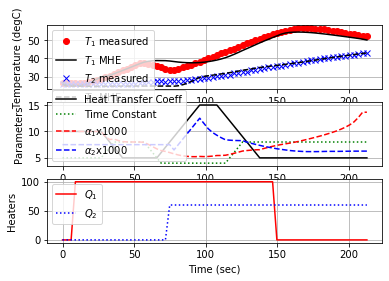

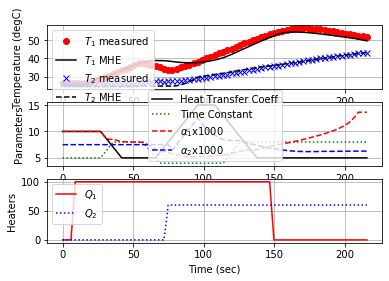

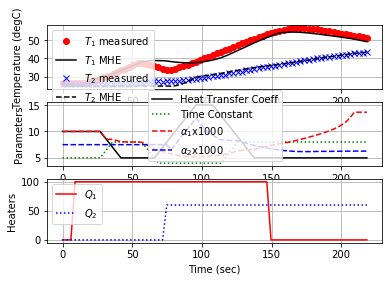

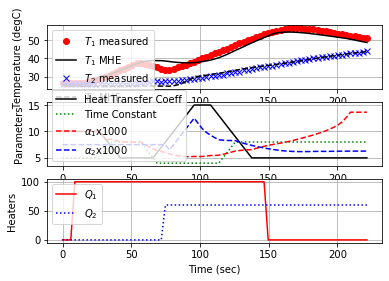

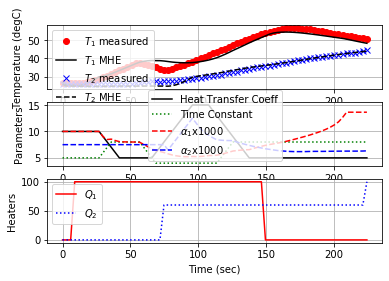

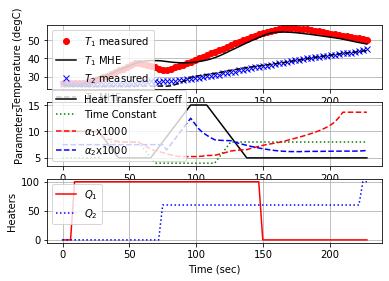

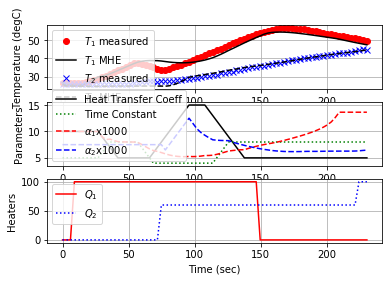

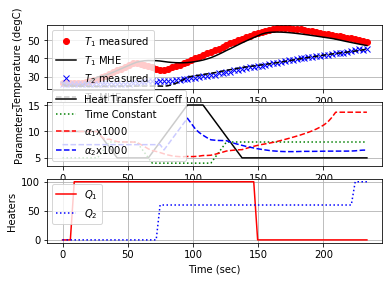

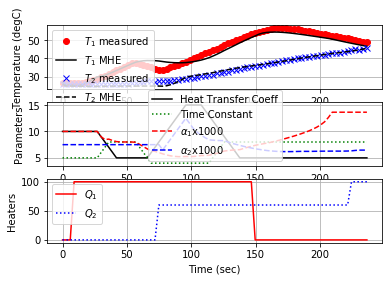

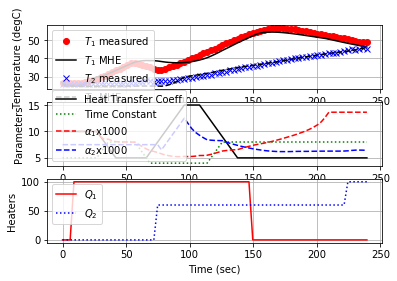

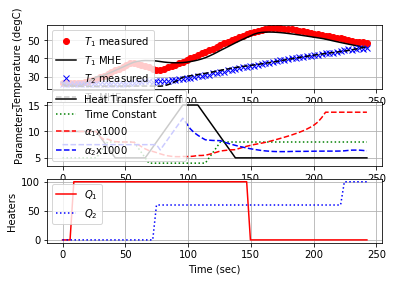

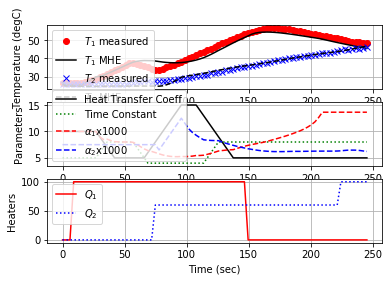

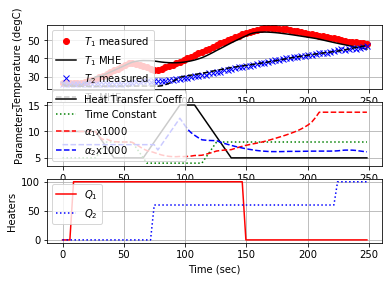

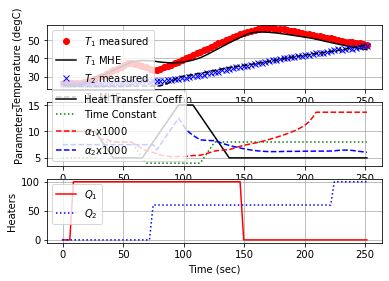

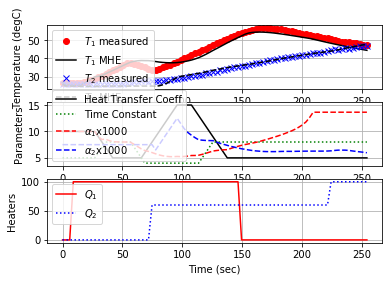

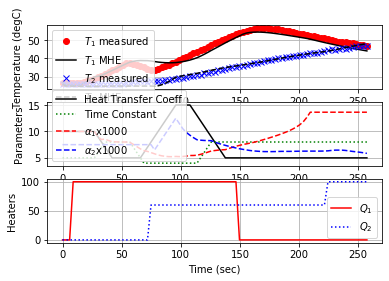

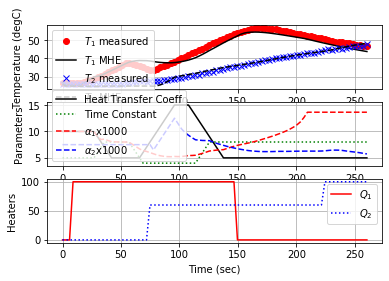

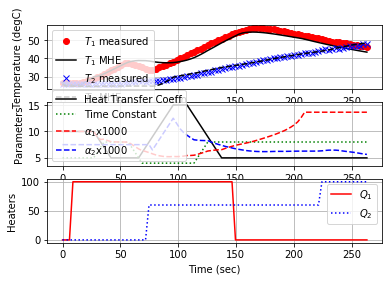

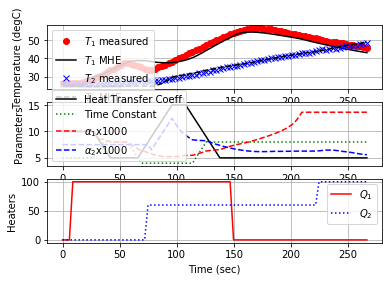

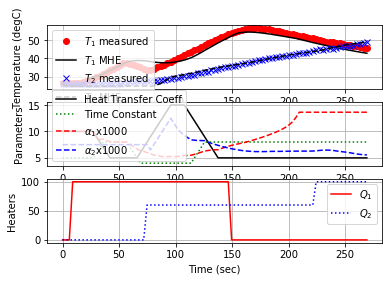

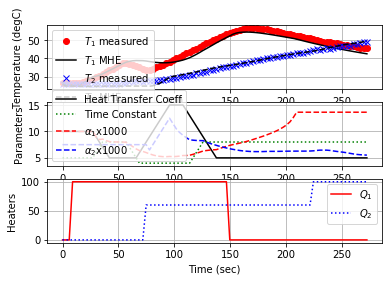

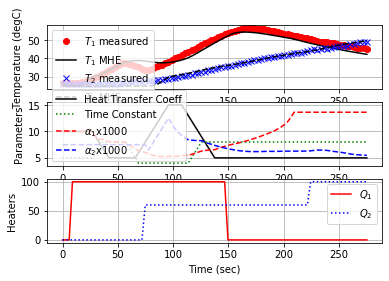

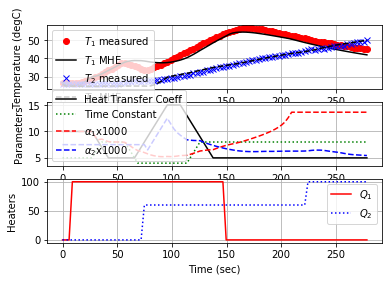

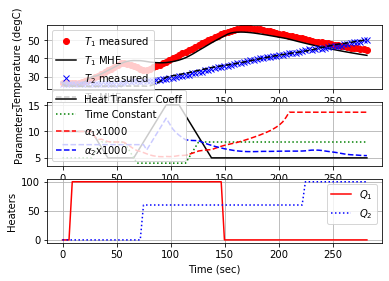

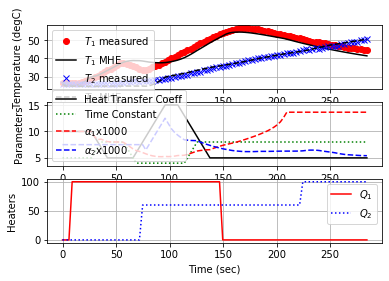

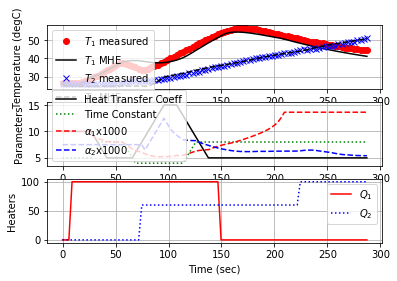

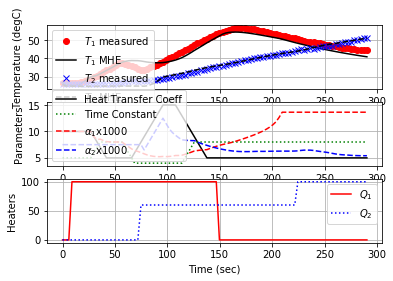

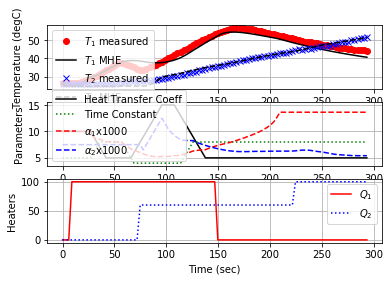

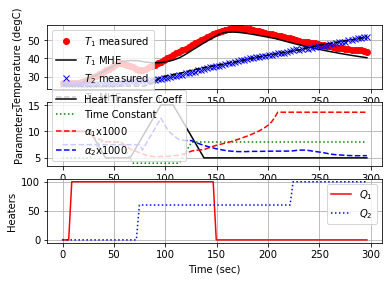

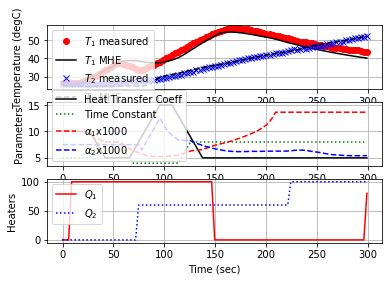

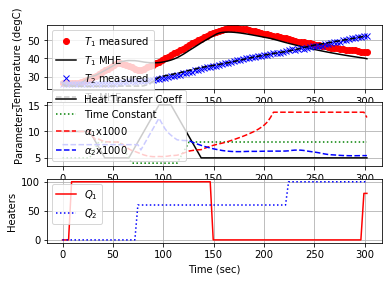

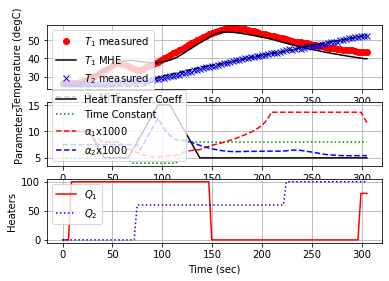

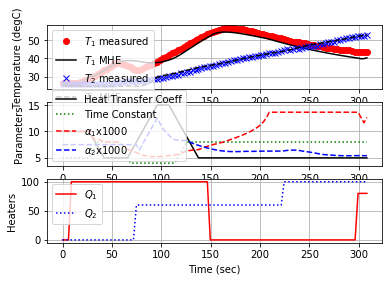

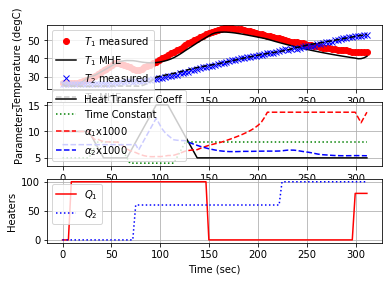

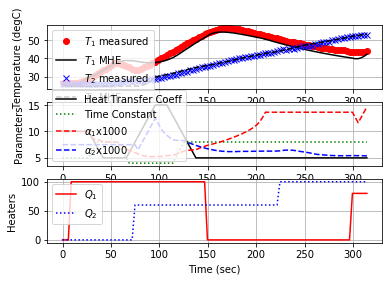

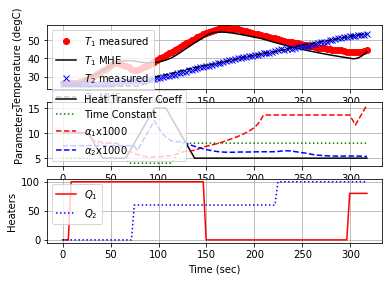

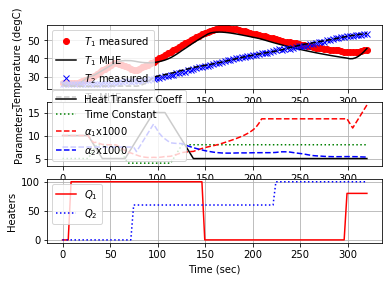

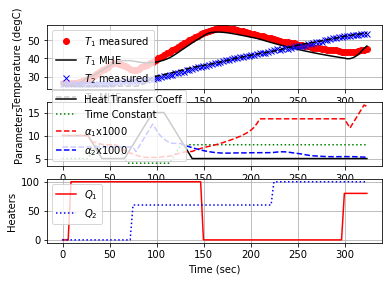

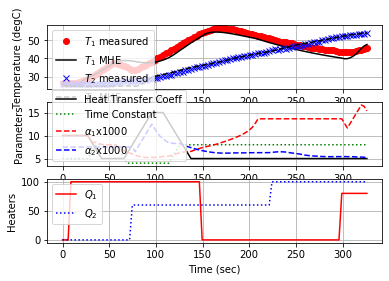

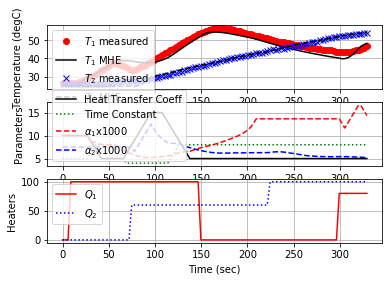

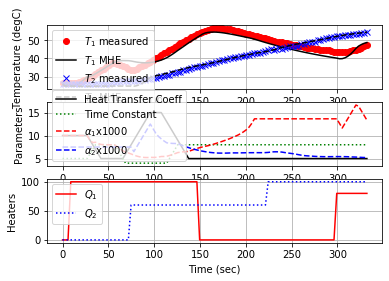

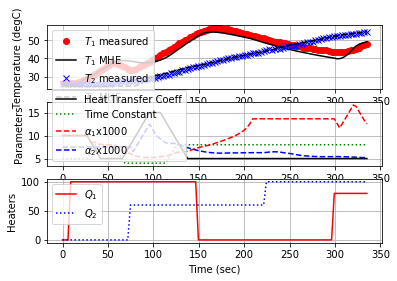

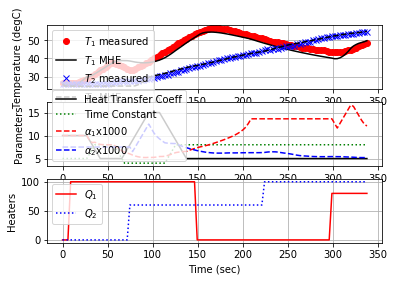

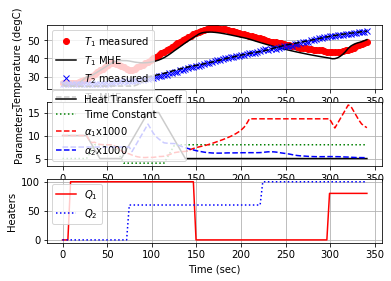

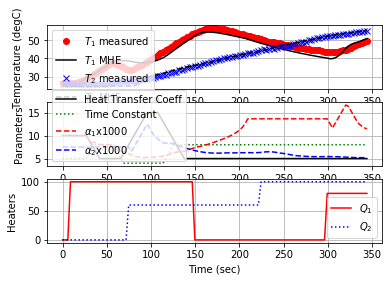

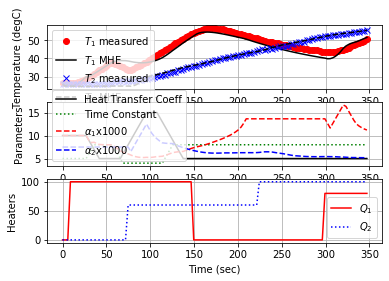

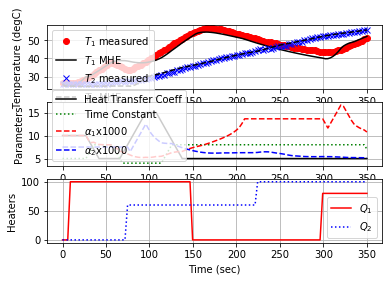

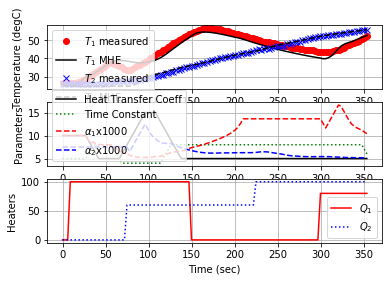

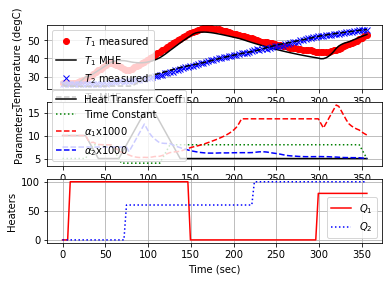

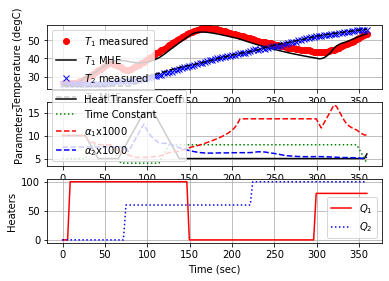

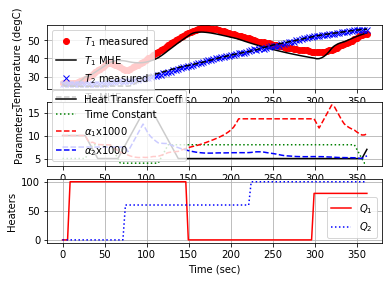

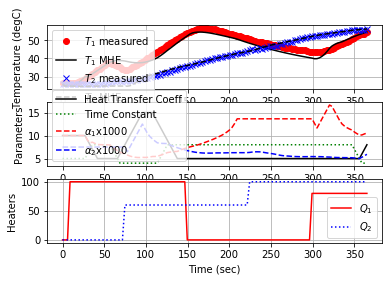

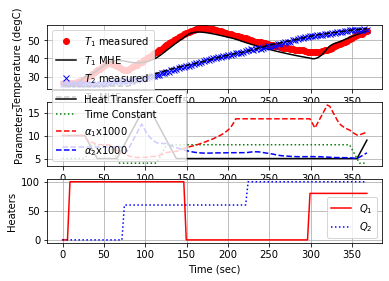

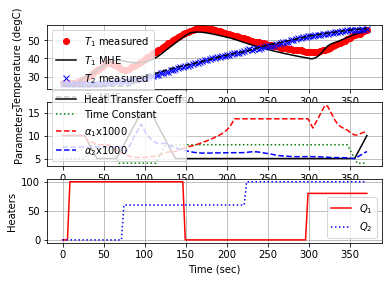

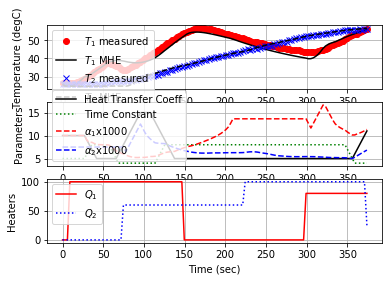

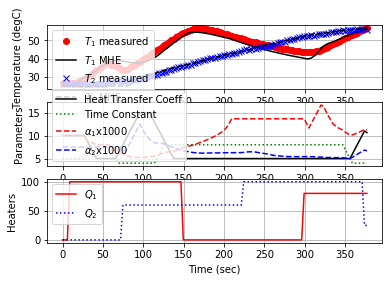

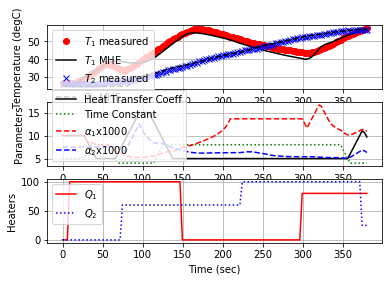

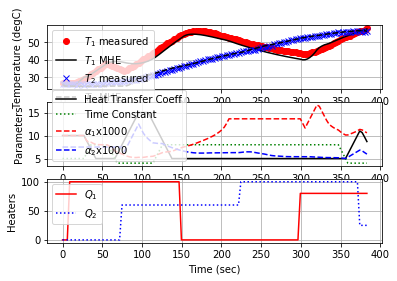

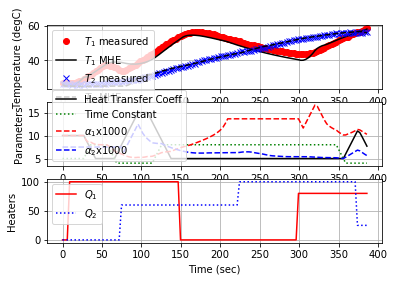

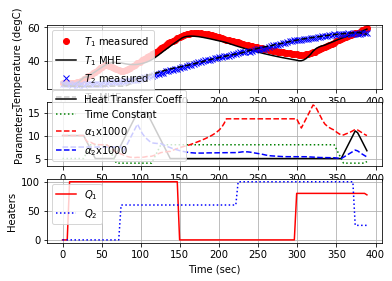

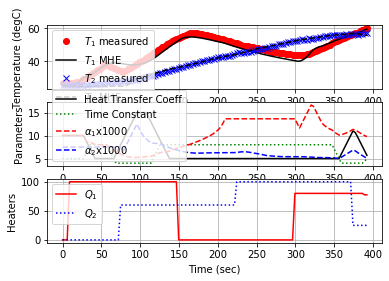

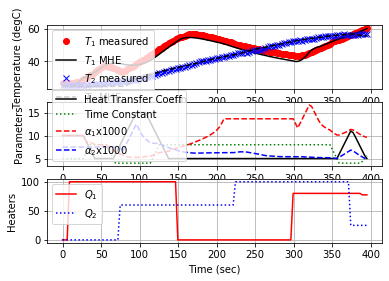

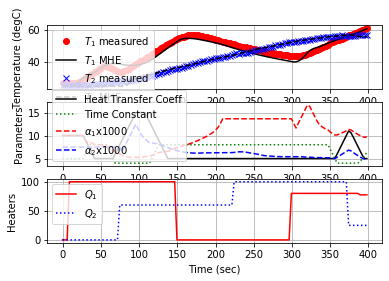

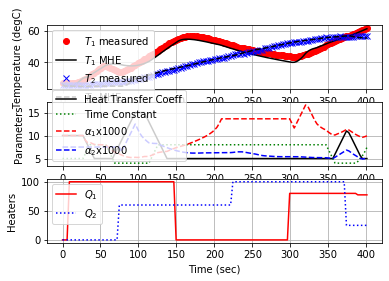

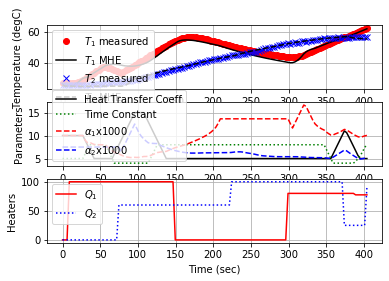

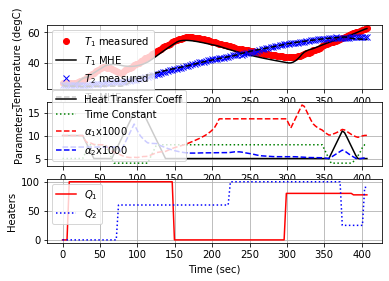

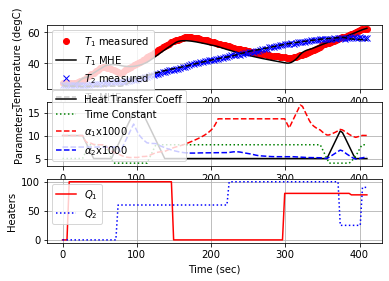

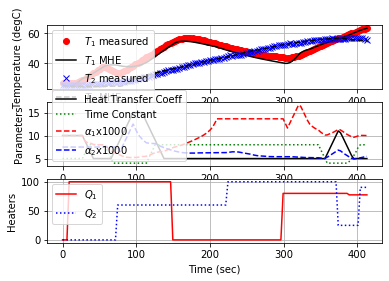

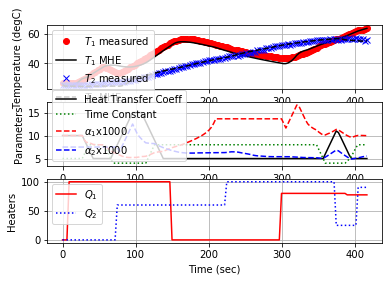

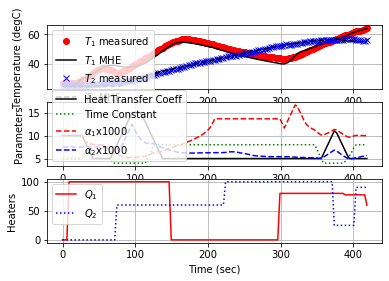

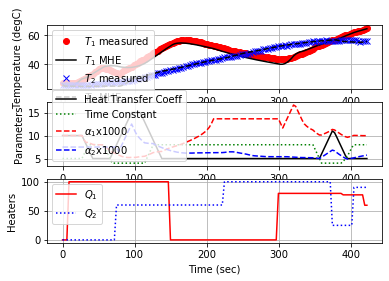

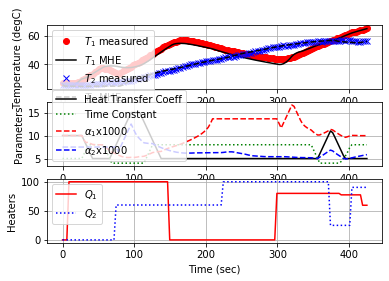

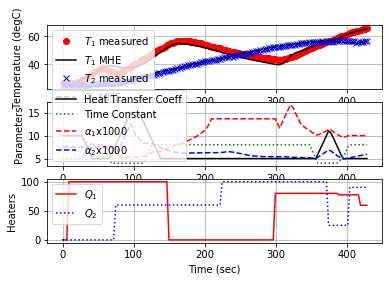

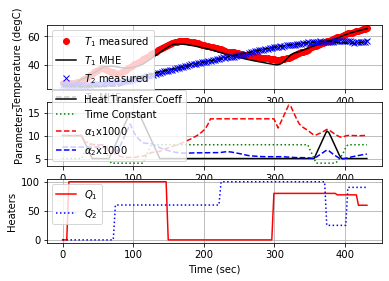

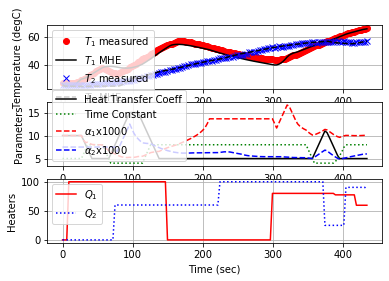

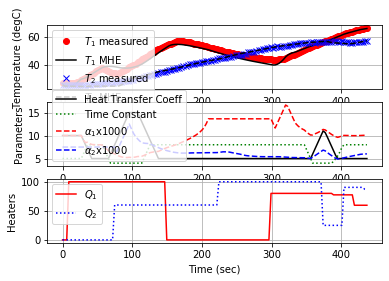

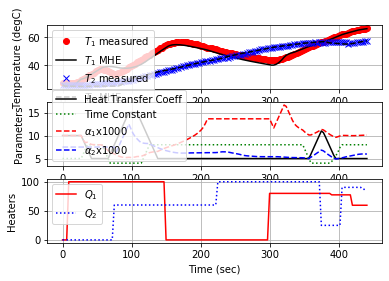

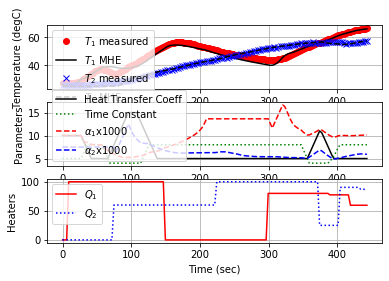

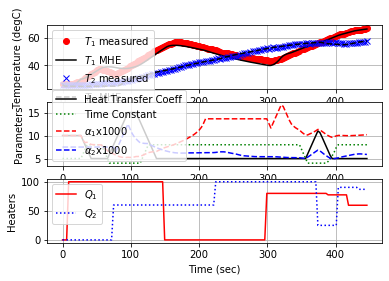

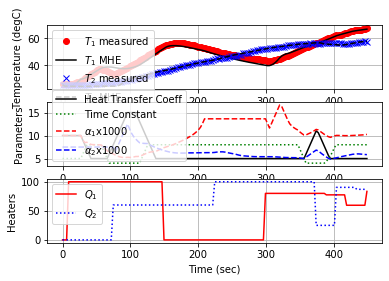

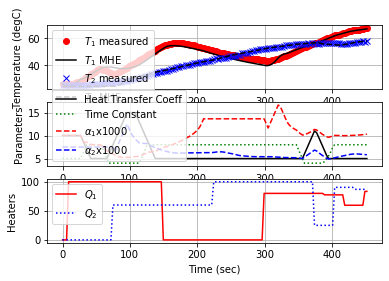

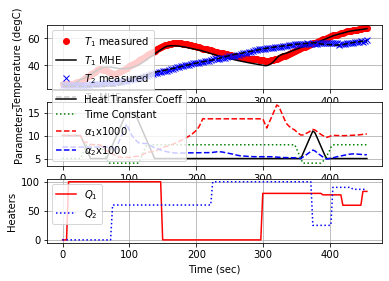

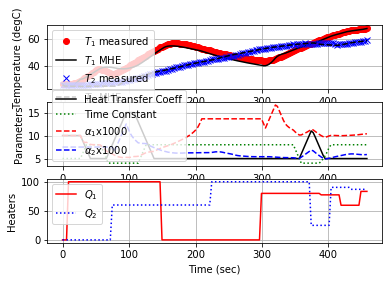

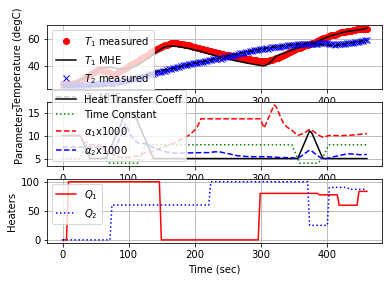

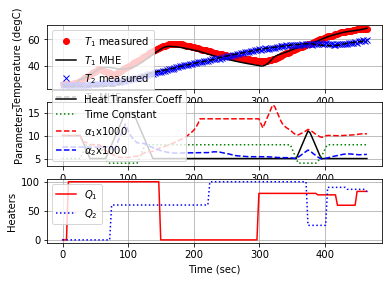

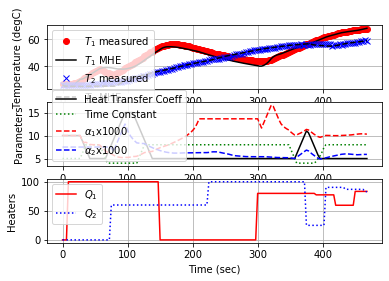

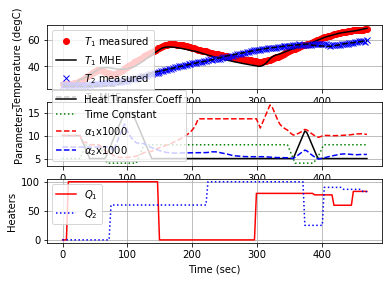

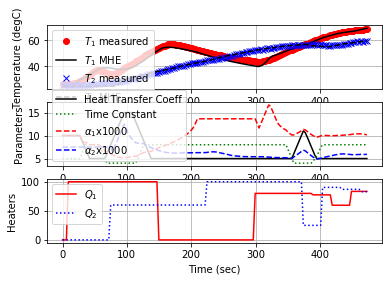

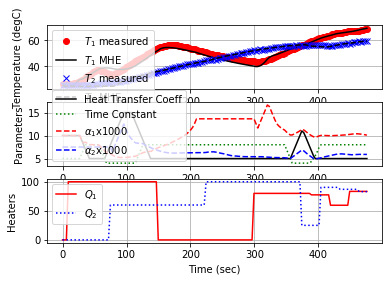

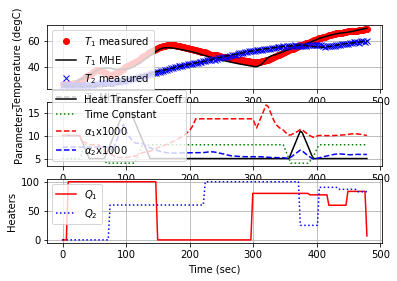

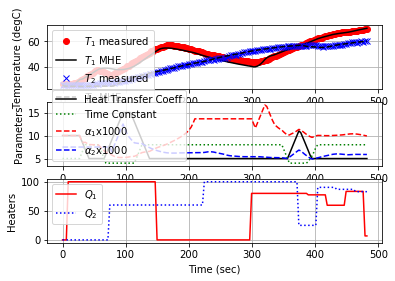

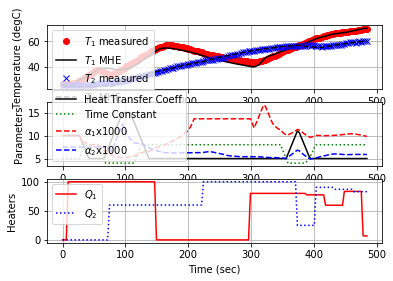

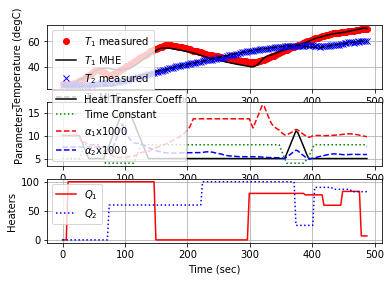

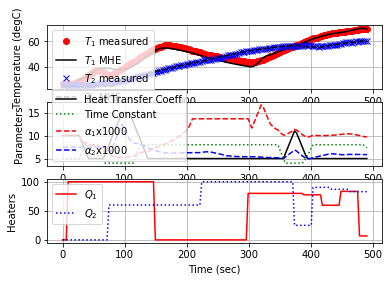

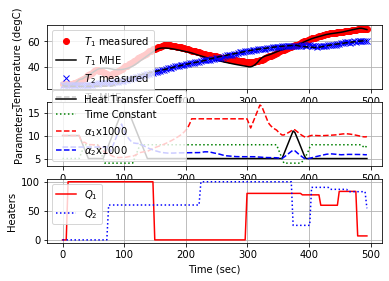

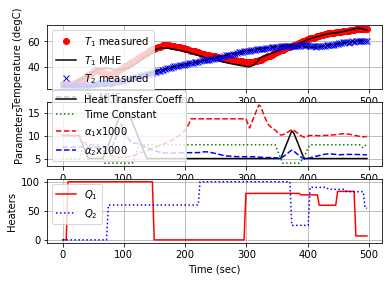

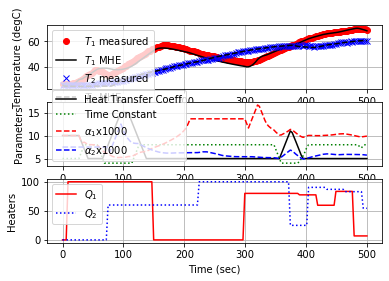

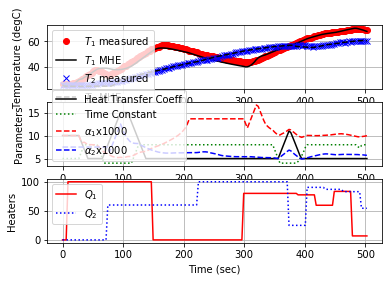

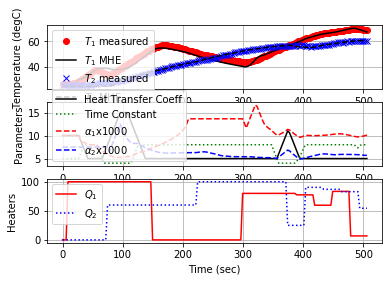

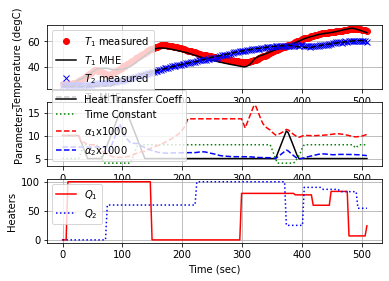

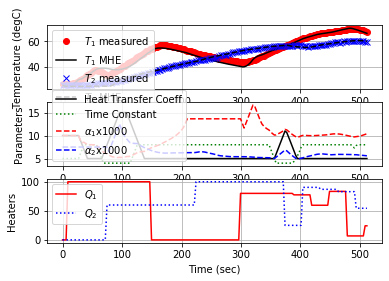

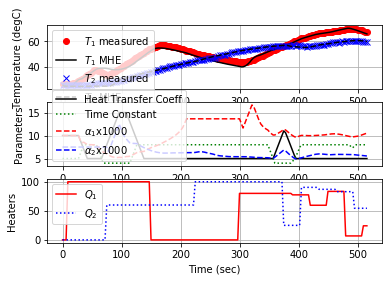

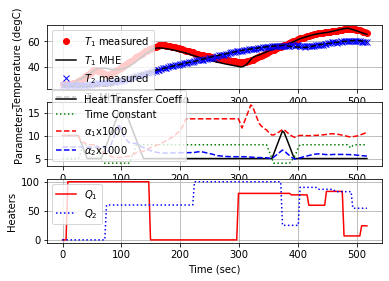

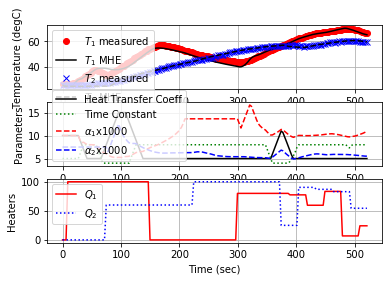

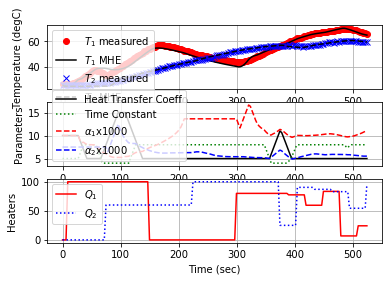

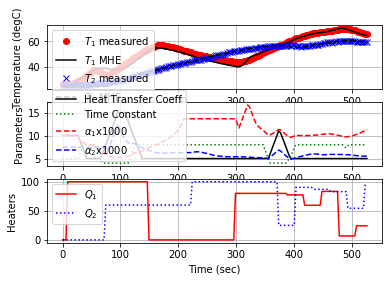

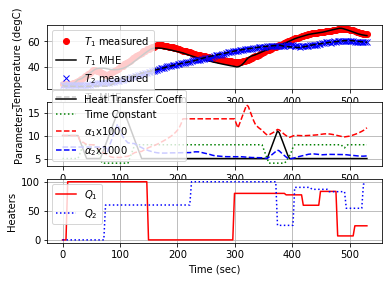

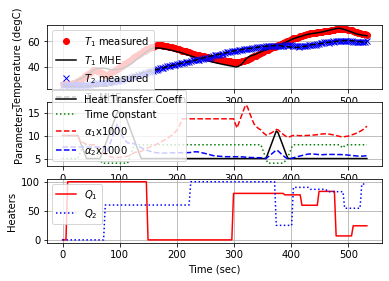

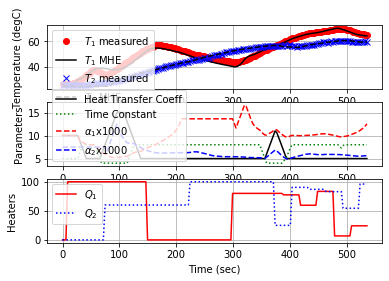

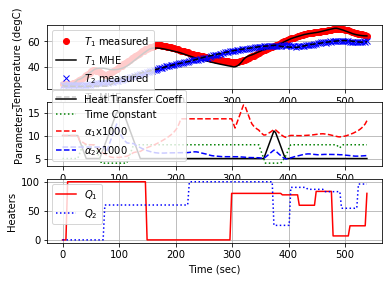

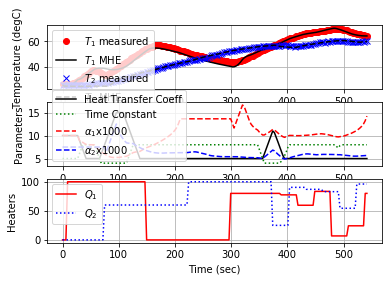

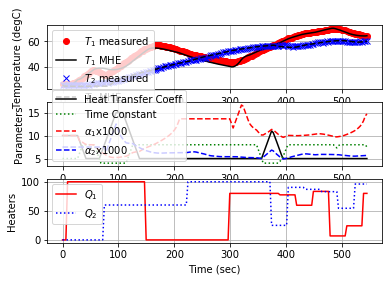

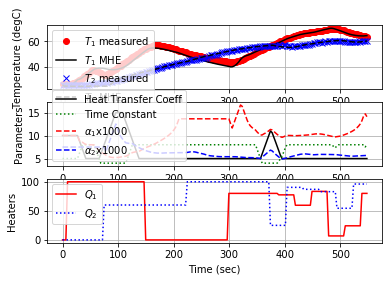

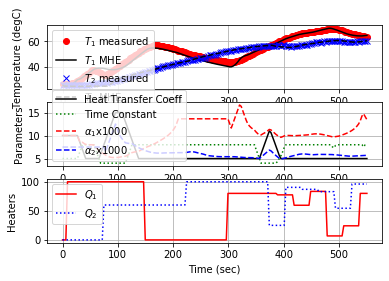

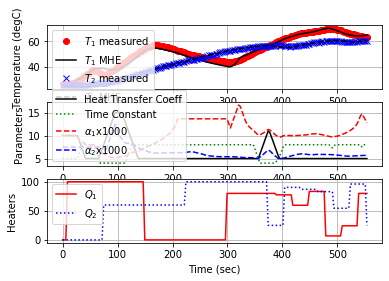

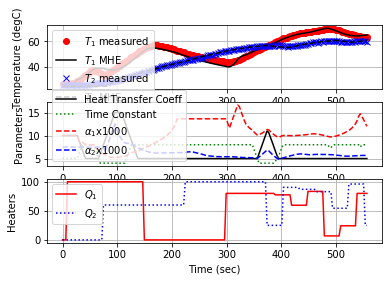

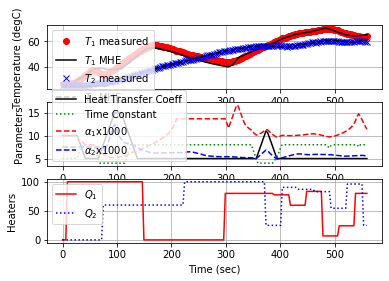

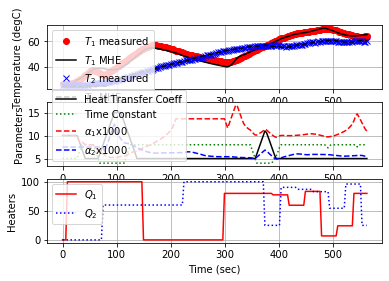

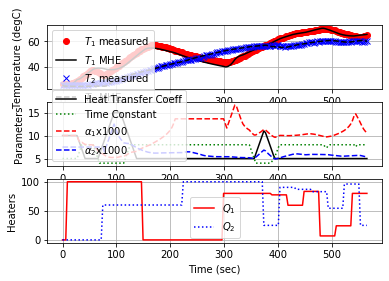

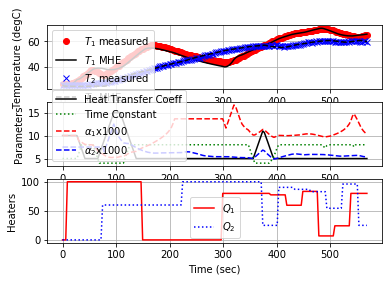

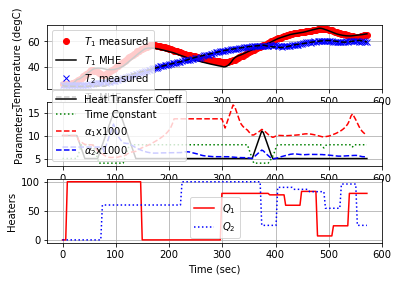

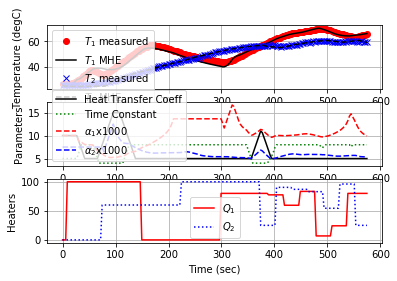

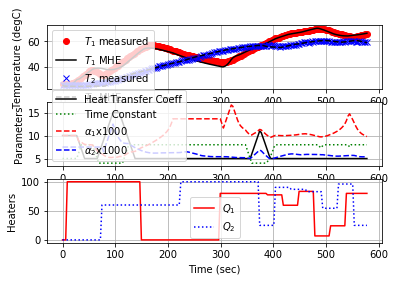

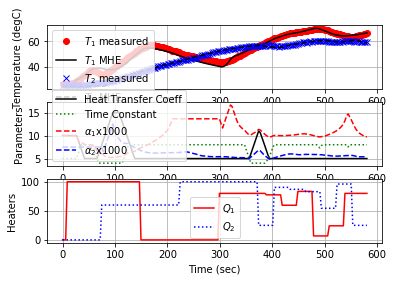

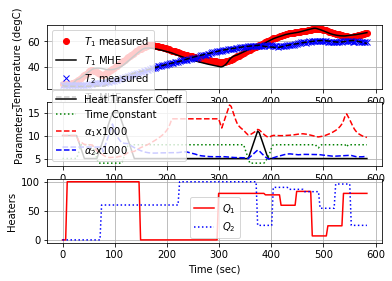

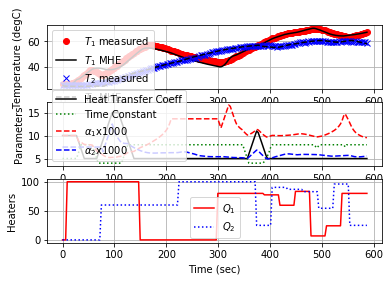

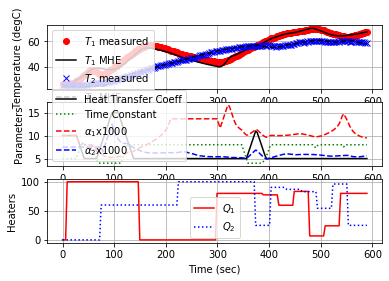

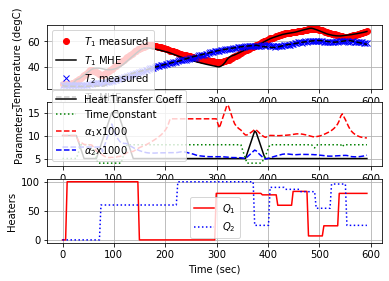

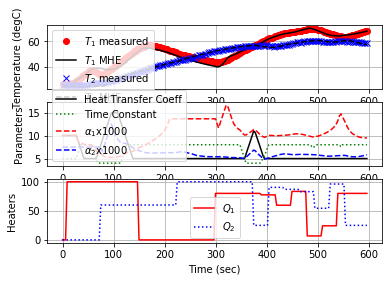

<Figure size 432x288 with 0 Axes>

In [2]:
import numpy as np
import time
import matplotlib.pyplot as plt
import random
# get gekko package with:
#   pip install gekko
from gekko import GEKKO
# get tclab package with:
#   pip install tclab
from tclab import TCLab

# Connect to Arduino
a = TCLab()

# Make an MP4 animation?
make_mp4 = False
if make_mp4:
    import imageio  # required to make animation
    import os
    try:
        os.mkdir('./figures')
    except:
        pass

# Final time
tf = 10 # min
# number of data points (1 pt every 3 seconds)
n = tf * 20 + 1

# Configure heater levels
# Percent Heater (0-100%)
Q1s = np.zeros(n)
Q2s = np.zeros(n)
# Heater random steps every 50 sec
# Alternate steps by Q1 and Q2
Q1s[3:]    = 100.0
Q1s[50:]   = 0.0 
Q1s[100:]  = 80.0

Q2s[25:]   = 60.0 
Q2s[75:]   = 100.0
Q2s[125:]  = 25.0

# rapid, random changes every 5 cycles between 50 and 100
for i in range(130,180):
    if i%10==0:
        Q1s[i:i+10] = random.random() * 100.0
    if (i+5)%10==0:
        Q2s[i:i+10] = random.random() * 100.0

# Record initial temperatures (degC)
T1m = a.T1 * np.ones(n)
T2m = a.T2 * np.ones(n)
# Store MHE values for plots
Tmhe1 = T1m[0] * np.ones(n)
Tmhe2 = T2m[0] * np.ones(n)
Umhe = 10.0 * np.ones(n)
taumhe = 5.0 * np.ones(n)
amhe1 = 0.01 * np.ones(n)
amhe2 = 0.0075 * np.ones(n)

#########################################################
# Initialize Model as Estimator
#########################################################
# change to remote=True for MacOS
m = GEKKO(name='tclab-mhe',remote=False)

# 60 second time horizon, 20 steps
m.time = np.linspace(0,60,21)

# Parameters to Estimate
U = m.FV(value=10,name='u')
U.STATUS = 0  # don't estimate initially
U.FSTATUS = 0 # no measurements
U.DMAX = 1
U.LOWER = 5
U.UPPER = 15

tau = m.FV(value=5,name='tau')
tau.STATUS = 0  # don't estimate initially
tau.FSTATUS = 0 # no measurements
tau.DMAX = 1
tau.LOWER = 4
tau.UPPER = 8

alpha1 = m.FV(value=0.01,name='a1')   # W / % heater
alpha1.STATUS = 0  # don't estimate initially
alpha1.FSTATUS = 0 # no measurements
alpha1.DMAX = 0.001
alpha1.LOWER = 0.003
alpha1.UPPER = 0.03

alpha2 = m.FV(value=0.0075,name='a2') # W / % heater
alpha2.STATUS = 0  # don't estimate initially
alpha2.FSTATUS = 0 # no measurements
alpha2.DMAX = 0.001
alpha2.LOWER = 0.002
alpha2.UPPER = 0.02

# Measured inputs
Q1 = m.MV(value=0,name='q1')
Q1.STATUS = 0  # don't estimate
Q1.FSTATUS = 1 # receive measurement

Q2 = m.MV(value=0,name='q2')
Q2.STATUS = 0  # don't estimate
Q2.FSTATUS = 1 # receive measurement

# State variables
TH1 = m.SV(value=T1m[0],name='th1')
TH2 = m.SV(value=T2m[0],name='th2')

# Measurements for model alignment
TC1 = m.CV(value=T1m[0],name='tc1')
TC1.STATUS = 1     # minimize error between simulation and measurement
TC1.FSTATUS = 1    # receive measurement
TC1.MEAS_GAP = 0.1 # measurement deadband gap
TC1.LOWER = 0
TC1.UPPER = 200

TC2 = m.CV(value=T2m[0],name='tc2')
TC2.STATUS = 1     # minimize error between simulation and measurement
TC2.FSTATUS = 1    # receive measurement
TC2.MEAS_GAP = 0.1 # measurement deadband gap
TC2.LOWER = 0
TC2.UPPER = 200

Ta = m.Param(value=23.0+273.15)     # K
mass = m.Param(value=4.0/1000.0)    # kg
Cp = m.Param(value=0.5*1000.0)      # J/kg-K    
A = m.Param(value=10.0/100.0**2)    # Area not between heaters in m^2
As = m.Param(value=2.0/100.0**2)    # Area between heaters in m^2
eps = m.Param(value=0.9)            # Emissivity
sigma = m.Const(5.67e-8)            # Stefan-Boltzmann

# Heater temperatures
T1 = m.Intermediate(TH1+273.15)
T2 = m.Intermediate(TH2+273.15)

# Heat transfer between two heaters
Q_C12 = m.Intermediate(U*As*(T2-T1)) # Convective
Q_R12 = m.Intermediate(eps*sigma*As*(T2**4-T1**4)) # Radiative

# Semi-fundamental correlations (energy balances)
m.Equation(TH1.dt() == (1.0/(mass*Cp))*(U*A*(Ta-T1) \
                    + eps * sigma * A * (Ta**4 - T1**4) \
                    + Q_C12 + Q_R12 \
                    + alpha1*Q1))

m.Equation(TH2.dt() == (1.0/(mass*Cp))*(U*A*(Ta-T2) \
                    + eps * sigma * A * (Ta**4 - T2**4) \
                    - Q_C12 - Q_R12 \
                    + alpha2*Q2))

# Empirical correlations (lag equations to emulate conduction)
m.Equation(tau * TC1.dt() == -TC1 + TH1)
m.Equation(tau * TC2.dt() == -TC2 + TH2)

# Global Options
m.options.IMODE   = 5 # MHE
m.options.EV_TYPE = 2 # Objective type
m.options.NODES   = 3 # Collocation nodes
m.options.SOLVER  = 3 # IPOPT
m.options.COLDSTART = 1 # COLDSTART on first cycle
##################################################################
# Create plot
plt.figure(figsize=(10,7))
plt.ion()
plt.show()

# Main Loop
start_time = time.time()
prev_time = start_time
tm = np.zeros(n)

try:
    for i in range(1,n):
        # Sleep time
        sleep_max = 3.0
        sleep = sleep_max - (time.time() - prev_time)
        if sleep>=0.01:
            time.sleep(sleep-0.01)
        else:
            time.sleep(0.01)

        # Record time and change in time
        t = time.time()
        dt = t - prev_time
        prev_time = t
        tm[i] = t - start_time

        # Read temperatures in Celsius 
        T1m[i] = a.T1
        T2m[i] = a.T2

        # Insert measurements
        TC1.MEAS = T1m[i]
        TC2.MEAS = T2m[i]
        Q1.MEAS = Q1s[i-1]
        Q2.MEAS = Q2s[i-1]

        # Start estimating U after 10 cycles (20 sec)
        if i==10:
            U.STATUS = 1
            tau.STATUS = 1
            alpha1.STATUS = 1
            alpha2.STATUS = 1

        # Predict Parameters and Temperatures with MHE
        m.solve(disp=False) 

        if m.options.APPSTATUS == 1:
            # Retrieve new values
            Tmhe1[i] = TC1.MODEL
            Tmhe2[i] = TC2.MODEL
            Umhe[i]  = U.NEWVAL
            taumhe[i] = tau.NEWVAL
            amhe1[i] = alpha1.NEWVAL
            amhe2[i] = alpha2.NEWVAL
        else:
            # Solution failed, copy prior solution
            Tmhe1[i] = Tmhe1[i-1]
            Tmhe2[i] = Tmhe1[i-1]
            Umhe[i]  = Umhe[i-1]
            taumhe[i] = taumhe[i-1]
            amhe1[i] = amhe1[i-1]
            amhe2[i] = amhe2[i-1]

        # Write new heater values (0-100)
        a.Q1(Q1s[i])
        a.Q2(Q2s[i])

        # Plot
        plt.clf()
        ax=plt.subplot(3,1,1)
        ax.grid()
        plt.plot(tm[0:i],T1m[0:i],'ro',label=r'$T_1$ measured')
        plt.plot(tm[0:i],Tmhe1[0:i],'k-',label=r'$T_1$ MHE')
        plt.plot(tm[0:i],T2m[0:i],'bx',label=r'$T_2$ measured')
        plt.plot(tm[0:i],Tmhe2[0:i],'k--',label=r'$T_2$ MHE')
        plt.ylabel('Temperature (degC)')
        plt.legend(loc=2)
        ax=plt.subplot(3,1,2)
        ax.grid()
        plt.plot(tm[0:i],Umhe[0:i],'k-',label='Heat Transfer Coeff')
        plt.plot(tm[0:i],taumhe[0:i],'g:',label='Time Constant')        
        plt.plot(tm[0:i],amhe1[0:i]*1000,'r--',label=r'$\alpha_1$x1000')
        plt.plot(tm[0:i],amhe2[0:i]*1000,'b--',label=r'$\alpha_2$x1000')
        plt.ylabel('Parameters')
        plt.legend(loc='best')
        ax=plt.subplot(3,1,3)
        ax.grid()
        plt.plot(tm[0:i],Q1s[0:i],'r-',label=r'$Q_1$')
        plt.plot(tm[0:i],Q2s[0:i],'b:',label=r'$Q_2$')
        plt.ylabel('Heaters')
        plt.xlabel('Time (sec)')
        plt.legend(loc='best')
        plt.draw()
        plt.pause(0.05)
        if make_mp4:
            filename='./figures/plot_'+str(i+10000)+'.png'
            plt.savefig(filename)

    # Turn off heaters
    a.Q1(0)
    a.Q2(0)
    # Save figure
    plt.savefig('tclab_mhe.png')

    # generate mp4 from png figures in batches of 350
    if make_mp4:
        images = []
        iset = 0
        for i in range(1,n):
            filename='./figures/plot_'+str(i+10000)+'.png'
            images.append(imageio.imread(filename))
            if ((i+1)%350)==0:
                imageio.mimsave('results_'+str(iset)+'.mp4', images)
                iset += 1
                images = []
        if images!=[]:
            imageio.mimsave('results_'+str(iset)+'.mp4', images)

# Allow user to end loop with Ctrl-C           
except KeyboardInterrupt:
    # Disconnect from Arduino
    a.Q1(0)
    a.Q2(0)
    print('Shutting down')
    a.close()
    plt.savefig('tclab_mhe.png')

# Make sure serial connection still closes when there's an error
except:           
    # Disconnect from Arduino
    a.Q1(0)
    a.Q2(0)
    print('Error: Shutting down')
    a.close()
    plt.savefig('tclab_mhe.png')
    raise